#### Experiment: 

Evaluate pruning by magnitude weighted by coactivations (more thorough evaluation), compare it to baseline (SET), in GSC. Applied only to linear layers

#### Motivation.

Check if results are consistently above baseline.

#### Conclusion


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import glob
import tabulate
import pprint
import click
import numpy as np
import pandas as pd
from ray.tune.commands import *
from nupic.research.frameworks.dynamic_sparse.common.browser import *

import matplotlib.pyplot as plt
from matplotlib import rcParams

%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set(style="whitegrid")
sns.set_palette("colorblind")

## Load and check data

In [3]:
exps = ['improved_mag_gsc_eval3', 'improved_mag_gsc_eval4']
paths = [os.path.expanduser("~/nta/results/{}".format(e)) for e in exps]
df = load_many(paths)

In [4]:
df.head(5)

,Experiment Name,train_acc_max,train_acc_max_epoch,train_acc_min,train_acc_min_epoch,train_acc_median,train_acc_last,val_acc_max,val_acc_max_epoch,val_acc_min,...,model,momentum,network,on_perc,optim_alg,pruning_early_stop,test_noise,use_kwinners,weight_decay,weight_prune_perc
0,"0_model=DSNNWeightedMag,on_perc=0.0",0.092960,19,0.087052,47,0.089689,0.089542,0.103448,22,0.000000,...,DSNNWeightedMag,0,GSCHeb,0.000,SGD,2,False,True,0.01,0.3
1,"1_model=DSNNMixedHeb,on_perc=0.0",0.091934,24,0.085880,33,0.089591,0.089542,0.103448,10,0.000000,...,DSNNMixedHeb,0,GSCHeb,0.000,SGD,2,False,True,0.01,0.3
2,"2_model=SparseModel,on_perc=0.0",0.092325,38,0.085587,99,0.089322,0.085587,0.103448,5,0.000000,...,SparseModel,0,GSCHeb,0.000,SGD,2,False,True,0.01,0.3
3,"3_model=DSNNWeightedMag,on_perc=0.005",0.399522,7,0.156821,0,0.199736,0.196026,0.394592,8,0.145376,...,DSNNWeightedMag,0,GSCHeb,0.005,SGD,2,False,True,0.01,0.3
4,"4_model=DSNNMixedHeb,on_perc=0.005",0.365931,11,0.181330,0,0.296016,0.296065,0.362461,11,0.087382,...,DSNNMixedHeb,0,GSCHeb,0.005,SGD,2,False,True,0.01,0.3


In [5]:
# replace hebbian prine
df['hebbian_prune_perc'] = df['hebbian_prune_perc'].replace(np.nan, 0.0, regex=True)
df['weight_prune_perc'] = df['weight_prune_perc'].replace(np.nan, 0.0, regex=True)

In [6]:
df.columns

Index(['Experiment Name', 'train_acc_max', 'train_acc_max_epoch',
       'train_acc_min', 'train_acc_min_epoch', 'train_acc_median',
       'train_acc_last', 'val_acc_max', 'val_acc_max_epoch', 'val_acc_min',
       'val_acc_min_epoch', 'val_acc_median', 'val_acc_last', 'epochs',
       'experiment_file_name', 'trial_time', 'mean_epoch_time',
       'batch_size_test', 'batch_size_train', 'data_dir', 'dataset_name',
       'debug_sparse', 'debug_weights', 'device', 'hebbian_grow',
       'hebbian_prune_perc', 'learning_rate', 'lr_gamma', 'lr_milestones',
       'lr_scheduler', 'model', 'momentum', 'network', 'on_perc', 'optim_alg',
       'pruning_early_stop', 'test_noise', 'use_kwinners', 'weight_decay',
       'weight_prune_perc'],
      dtype='object')

In [7]:
df.shape

(209, 40)

In [8]:
df.iloc[1]

Experiment Name                          1_model=DSNNMixedHeb,on_perc=0.0
train_acc_max                                                   0.0919344
train_acc_max_epoch                                                    24
train_acc_min                                                   0.0858803
train_acc_min_epoch                                                    33
train_acc_median                                                0.0895909
train_acc_last                                                   0.089542
val_acc_max                                                      0.103448
val_acc_max_epoch                                                      10
val_acc_min                                                             0
val_acc_min_epoch                                                       0
val_acc_median                                                  0.0971787
val_acc_last                                                    0.0971787
epochs                                

In [9]:
df.groupby('model')['model'].count()

model
DSNNMixedHeb       70
DSNNWeightedMag    70
SparseModel        69
Name: model, dtype: int64

 ## Analysis

Experiment Details

In [10]:
# Did any  trials failed?
df[df["epochs"]<30]["epochs"].count()

5

In [11]:
# Removing failed or incomplete trials
df_origin = df.copy()
df = df_origin[df_origin["epochs"]>=30]
df.shape

(204, 40)

In [12]:
# which ones failed?
# failed, or still ongoing?
df_origin['failed'] = df_origin["epochs"]<30
df_origin[df_origin['failed']]['epochs']

204    21
205    23
206    27
207    16
208     2
Name: epochs, dtype: int64

In [13]:
# helper functions
def mean_and_std(s):
    return "{:.3f} ± {:.3f}".format(s.mean(), s.std())

def round_mean(s):
    return "{:.0f}".format(round(s.mean()))

stats = ['min', 'max', 'mean', 'std']

def agg(columns, filter=None, round=3):
    if filter is None:
        return (df.groupby(columns)
             .agg({'val_acc_max_epoch': round_mean,
                   'val_acc_max': stats,                
                   'model': ['count']})).round(round)
    else:
        return (df[filter].groupby(columns)
             .agg({'val_acc_max_epoch': round_mean,
                   'val_acc_max': stats,                
                   'model': ['count']})).round(round)


##### Does improved weight pruning outperforms regular SET

In [22]:
agg(['model'])

val_acc_max_epoch val_acc_max                      model
                       round_mean         min    max   mean    std count
model                                                                   
DSNNMixedHeb                   53       0.103  0.954  0.817  0.232    68
DSNNWeightedMag                59       0.103  0.952  0.830  0.226    68
SparseModel                    73       0.103  0.949  0.801  0.242    68

In [15]:
agg(['on_perc'])

val_acc_max_epoch val_acc_max                      model
               round_mean         min    max   mean    std count
on_perc                                                         
0.000                  10       0.103  0.106  0.104  0.001    12
0.005                  23       0.218  0.425  0.349  0.065    12
0.010                  33       0.609  0.732  0.664  0.043    12
0.015                  38       0.735  0.822  0.780  0.029    12
0.020                  48       0.770  0.880  0.832  0.031    12
0.025                  54       0.841  0.905  0.876  0.023     9
0.030                  73       0.865  0.915  0.891  0.017     9
0.035                  64       0.878  0.922  0.899  0.016     9
0.040                  70       0.895  0.927  0.913  0.011     9
0.045                  72       0.910  0.942  0.927  0.010     9
0.050                  76       0.921  0.938  0.927  0.005     9
0.055                  75       0.928  0.942  0.933  0.005     9
0.060                  73       0.931  0.940  0.934  0.003     9
0.065                  82       0.929  0.945  0.939  0.006     9
0.070                  72       0.924  0.947  0.938  0.007     9
0.075                  81       0.939  0.949  0.945  0.003     9
0.080                  82       0.938  0.948  0.943  0.003     9
0.085                  83       0.938  0.951  0.945  0.004     9
0.090                  80       0.944  0.951  0.948  0.002     9
0.095                  76       0.943  0.949  0.946  0.002     9
0.100                  83       0.946  0.954  0.949  0.003     9

In [16]:
agg(['on_perc', 'model'])

val_acc_max_epoch val_acc_max                       \
                               round_mean         min    max   mean    std   
on_perc model                                                                
0.000   DSNNMixedHeb                    6       0.103  0.103  0.103  0.000   
        DSNNWeightedMag                12       0.103  0.103  0.103  0.000   
        SparseModel                    12       0.103  0.106  0.104  0.001   
0.005   DSNNMixedHeb                   10       0.351  0.396  0.368  0.020   
        DSNNWeightedMag                 8       0.395  0.425  0.409  0.013   
        SparseModel                    52       0.218  0.303  0.270  0.039   
0.010   DSNNMixedHeb                   12       0.639  0.689  0.658  0.022   
        DSNNWeightedMag                15       0.656  0.732  0.710  0.036   
        SparseModel                    72       0.609  0.640  0.625  0.013   
0.015   DSNNMixedHeb                   19       0.735  0.789  0.773  0.025   
        DSNNWeightedMag                22       0.805  0.822  0.813  0.008   
        SparseModel                    73       0.745  0.765  0.756  0.009   
0.020   DSNNMixedHeb                   39       0.819  0.852  0.836  0.015   
        DSNNWeightedMag                42       0.830  0.880  0.859  0.025   
        SparseModel                    61       0.770  0.819  0.802  0.022   
0.025   DSNNMixedHeb                   36       0.873  0.877  0.876  0.002   
        DSNNWeightedMag                43       0.899  0.905  0.902  0.003   
        SparseModel                    82       0.841  0.861  0.850  0.010   
0.030   DSNNMixedHeb                   58       0.870  0.890  0.883  0.012   
        DSNNWeightedMag                72       0.902  0.915  0.910  0.007   
        SparseModel                    89       0.865  0.891  0.880  0.014   
0.035   DSNNMixedHeb                   54       0.894  0.912  0.903  0.009   
        DSNNWeightedMag                72       0.900  0.922  0.913  0.011   
        SparseModel                    66       0.878  0.882  0.880  0.002   
0.040   DSNNMixedHeb                   40       0.911  0.916  0.914  0.002   
        DSNNWeightedMag                83       0.922  0.927  0.925  0.003   
        SparseModel                    86       0.895  0.904  0.900  0.005   
0.045   DSNNMixedHeb                   66       0.927  0.930  0.928  0.002   
        DSNNWeightedMag                77       0.933  0.942  0.937  0.005   
        SparseModel                    75       0.910  0.921  0.916  0.006   
...                                   ...         ...    ...    ...    ...   
0.055   DSNNMixedHeb                   77       0.935  0.942  0.938  0.003   
        DSNNWeightedMag                69       0.929  0.936  0.933  0.003   
        SparseModel                    79       0.928  0.933  0.929  0.003   
0.060   DSNNMixedHeb                   69       0.933  0.940  0.936  0.004   
        DSNNWeightedMag                64       0.933  0.937  0.935  0.002   
        SparseModel                    87       0.931  0.934  0.933  0.002   
0.065   DSNNMixedHeb                   86       0.942  0.945  0.944  0.001   
        DSNNWeightedMag                76       0.941  0.943  0.942  0.001   
        SparseModel                    85       0.929  0.934  0.931  0.002   
0.070   DSNNMixedHeb                   70       0.936  0.945  0.940  0.005   
        DSNNWeightedMag                81       0.940  0.947  0.944  0.004   
        SparseModel                    65       0.924  0.935  0.931  0.007   
0.075   DSNNMixedHeb                   70       0.939  0.949  0.944  0.005   
        DSNNWeightedMag                94       0.945  0.948  0.947  0.001   
        SparseModel                    79       0.940  0.944  0.943  0.002   
0.080   DSNNMixedHeb                   77       0.943  0.944  0.943  0.000   
        DSNNWeightedMag                77       0.944  0.948  0.947  0.002   
        SparseModel                    91     

In [17]:
# translate model names
rcParams['figure.figsize'] = 16, 8
d = {
    'DSNNWeightedMag': 'DSNN',
    'DSNNMixedHeb': 'SET',
    'SparseModel': 'Static',        
}
df_plot = df.copy()
df_plot['model'] = df_plot['model'].apply(lambda x: d[x])

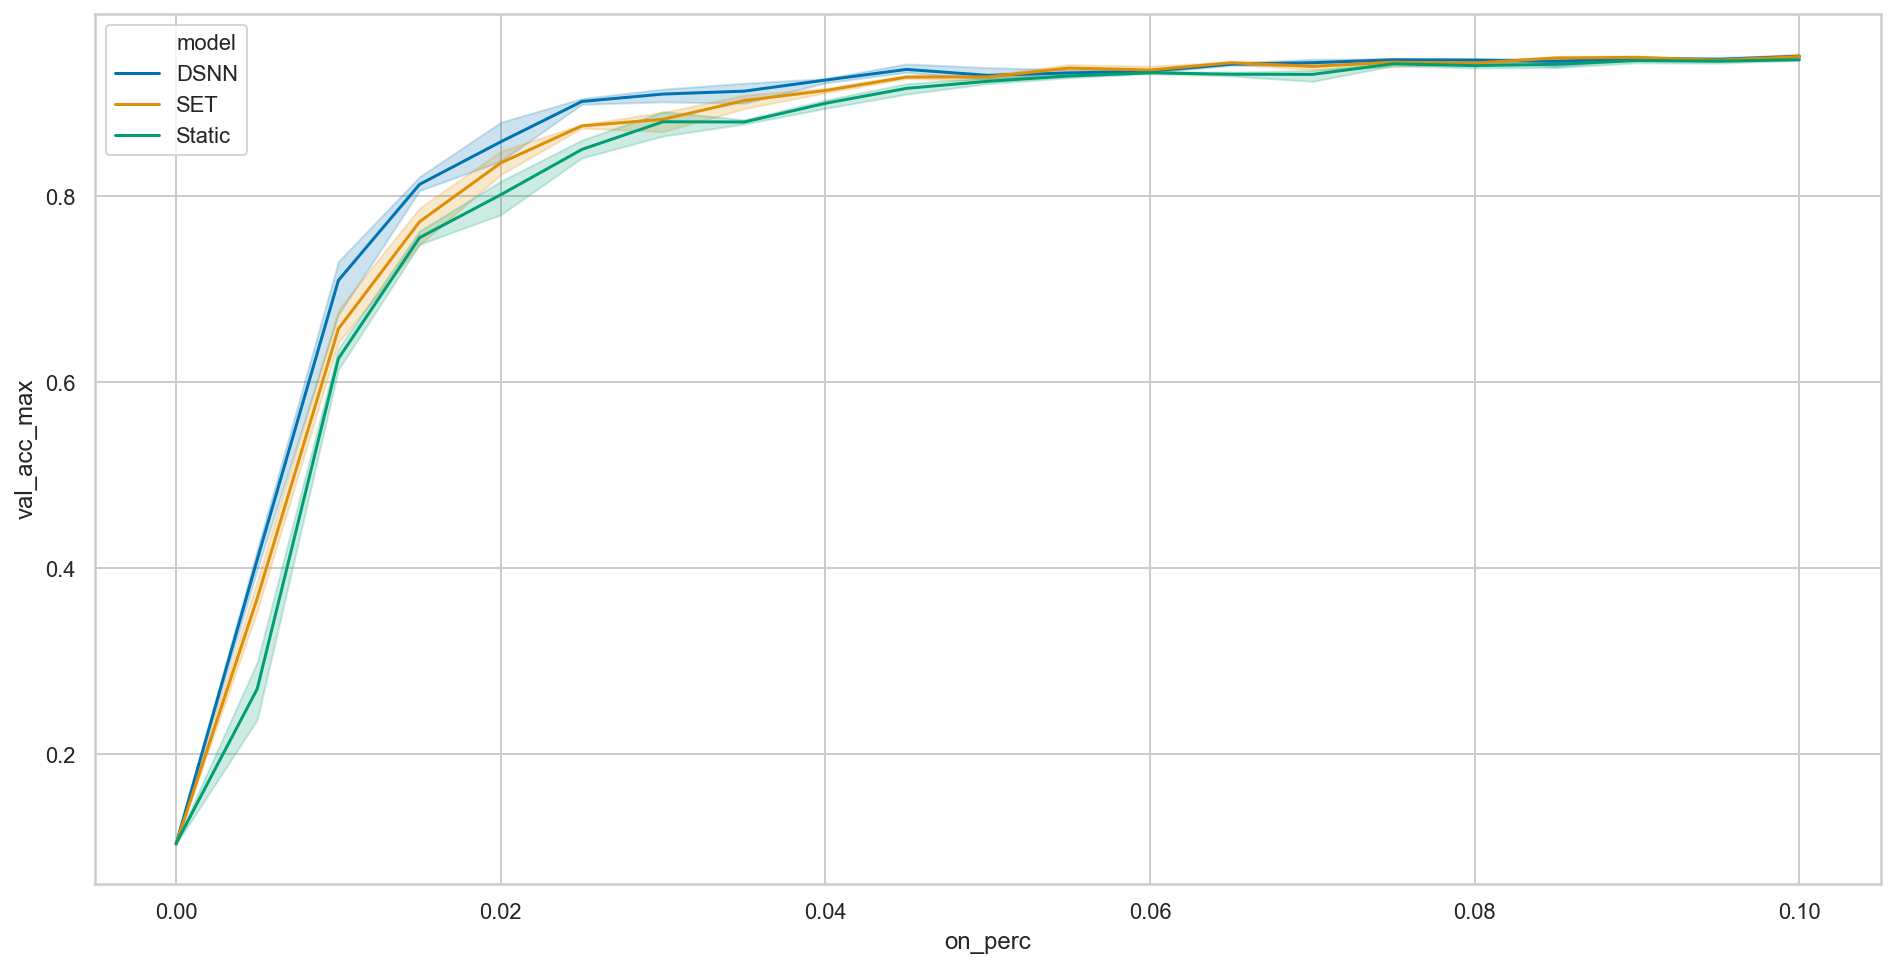

In [18]:
# sns.scatterplot(data=df_plot, x='on_perc', y='val_acc_max', hue='model')
sns.lineplot(data=df_plot, x='on_perc', y='val_acc_max', hue='model')

(0.8, 0.98)

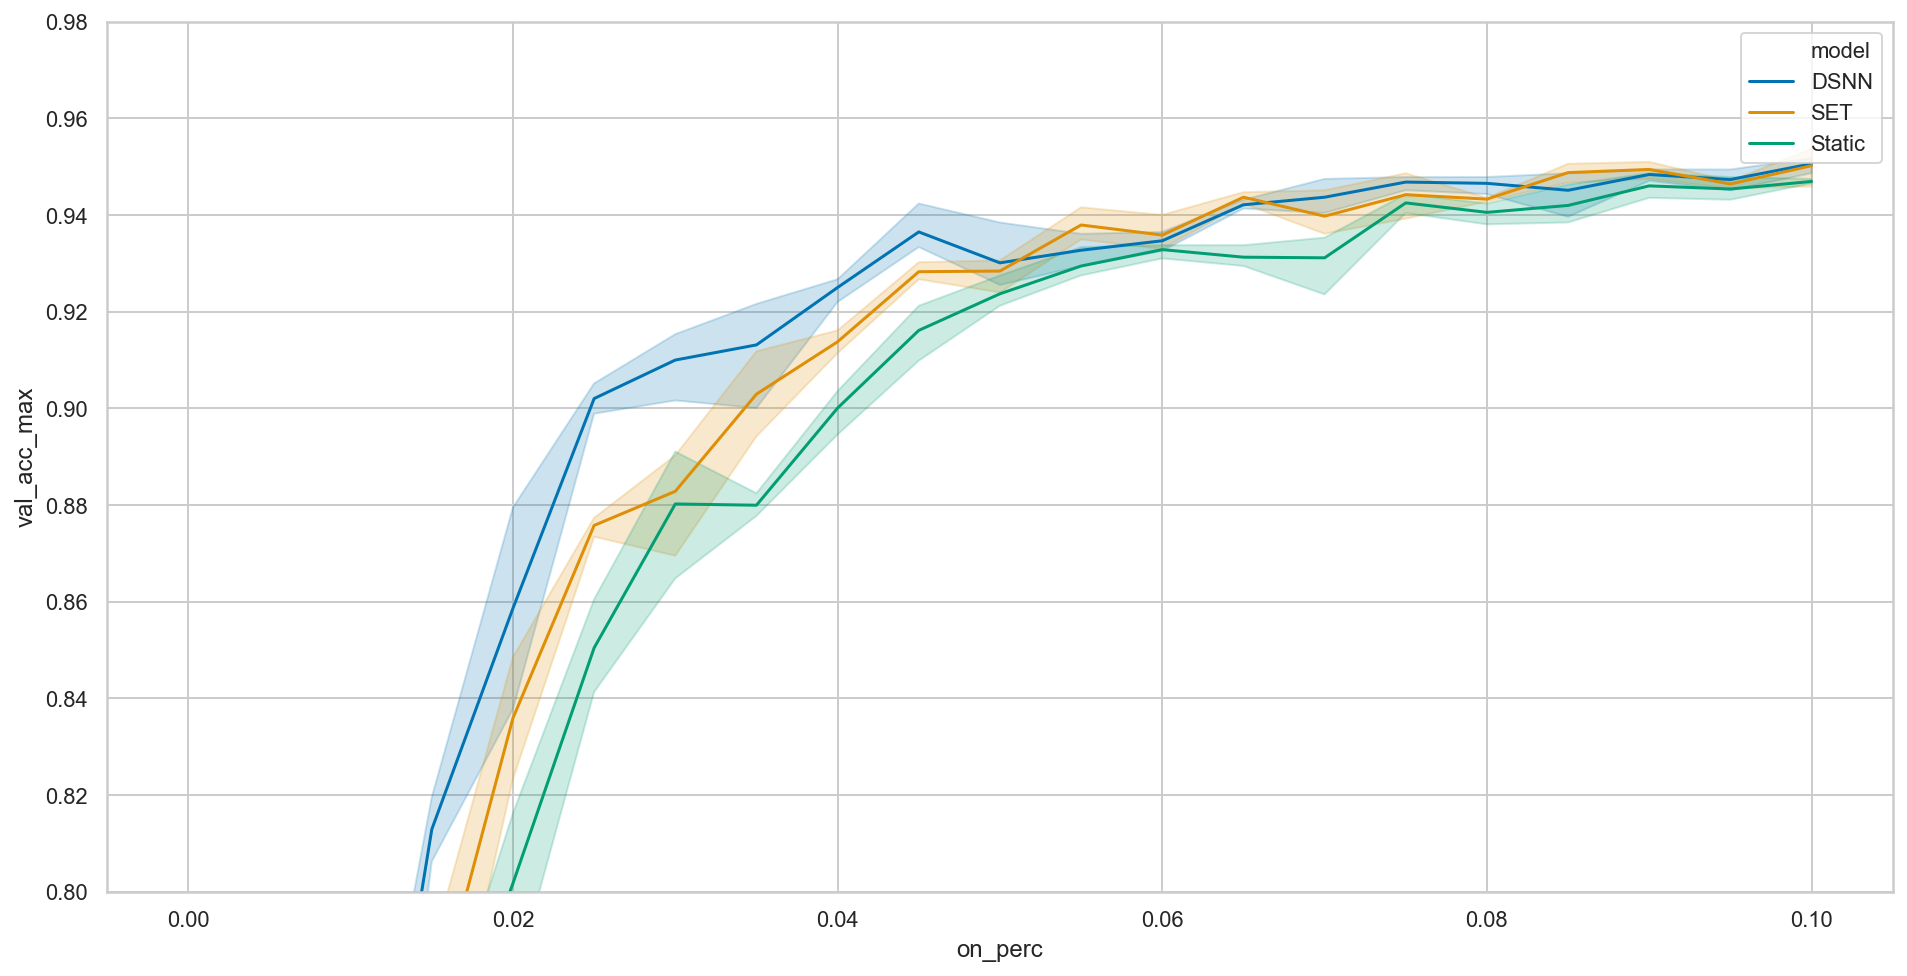

In [19]:
# sns.scatterplot(data=df_plot, x='on_perc', y='val_acc_max', hue='model')
sns.lineplot(data=df_plot, x='on_perc', y='val_acc_max', hue='model')
plt.ylim(0.8,0.98)

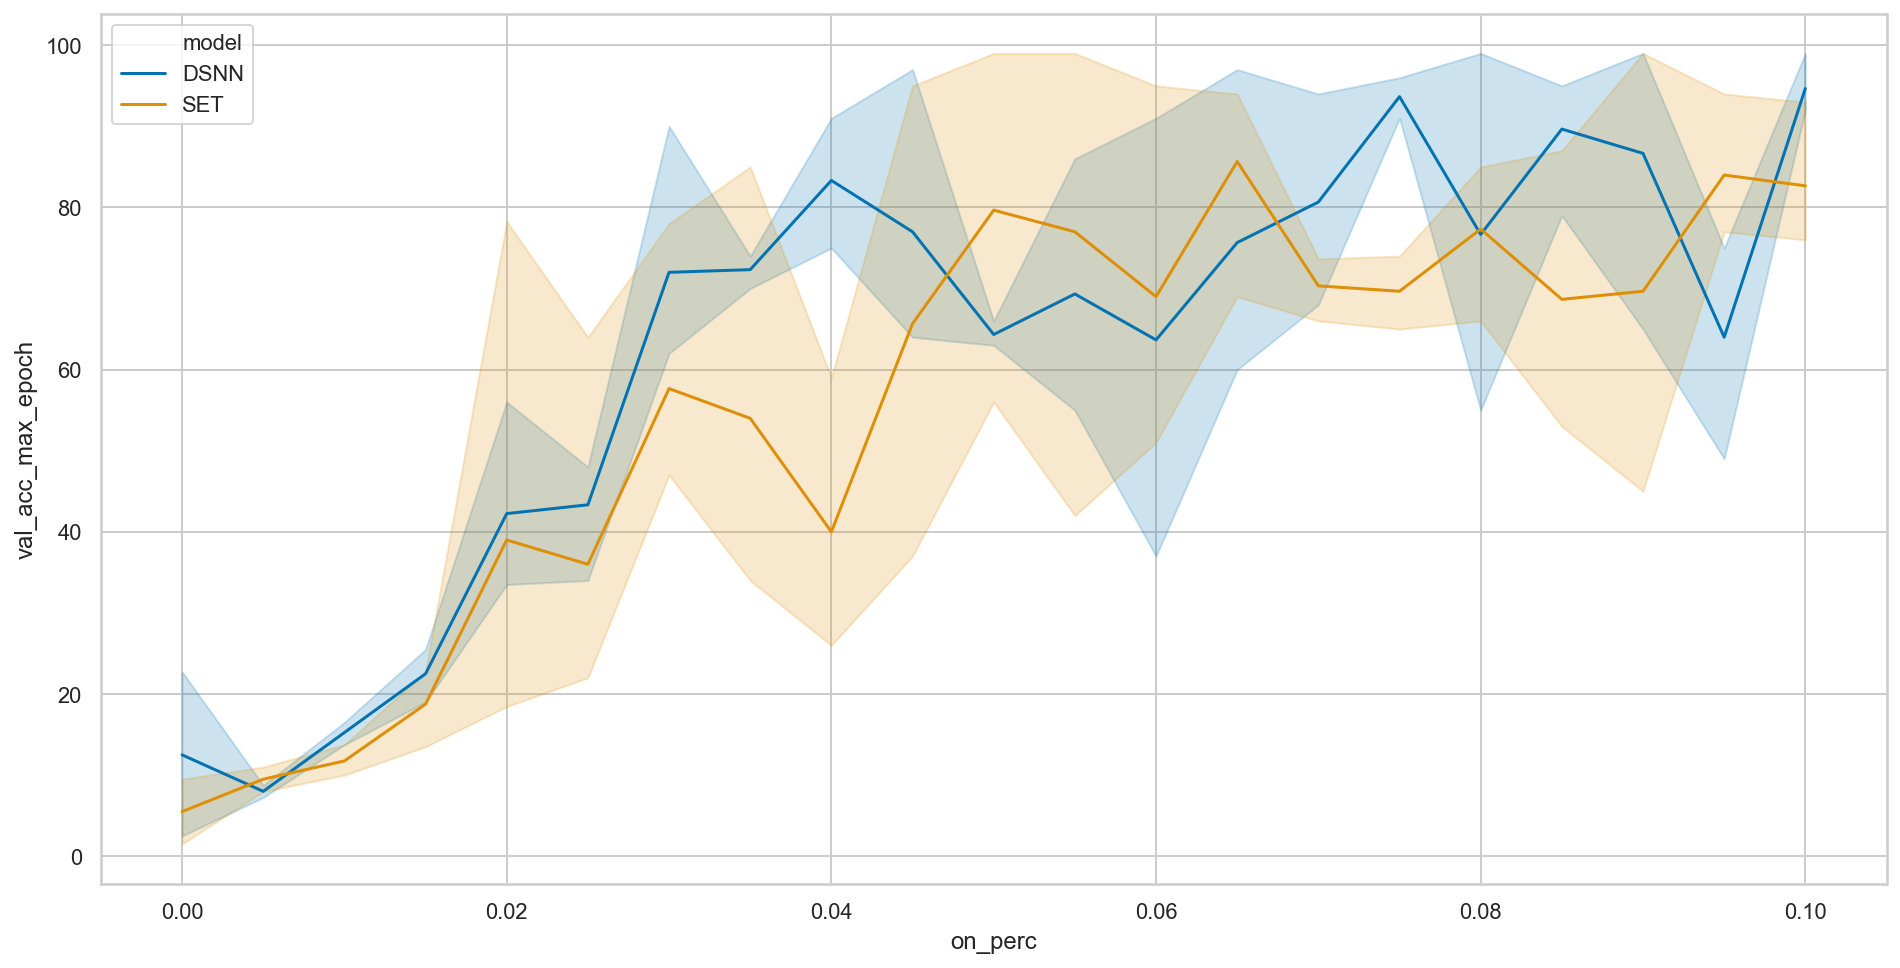

In [20]:
rcParams['figure.figsize'] = 16, 8
filter = df_plot['model'] != 'Static'
sns.lineplot(data=df_plot[filter], x='on_perc', y='val_acc_max_epoch', hue='model')

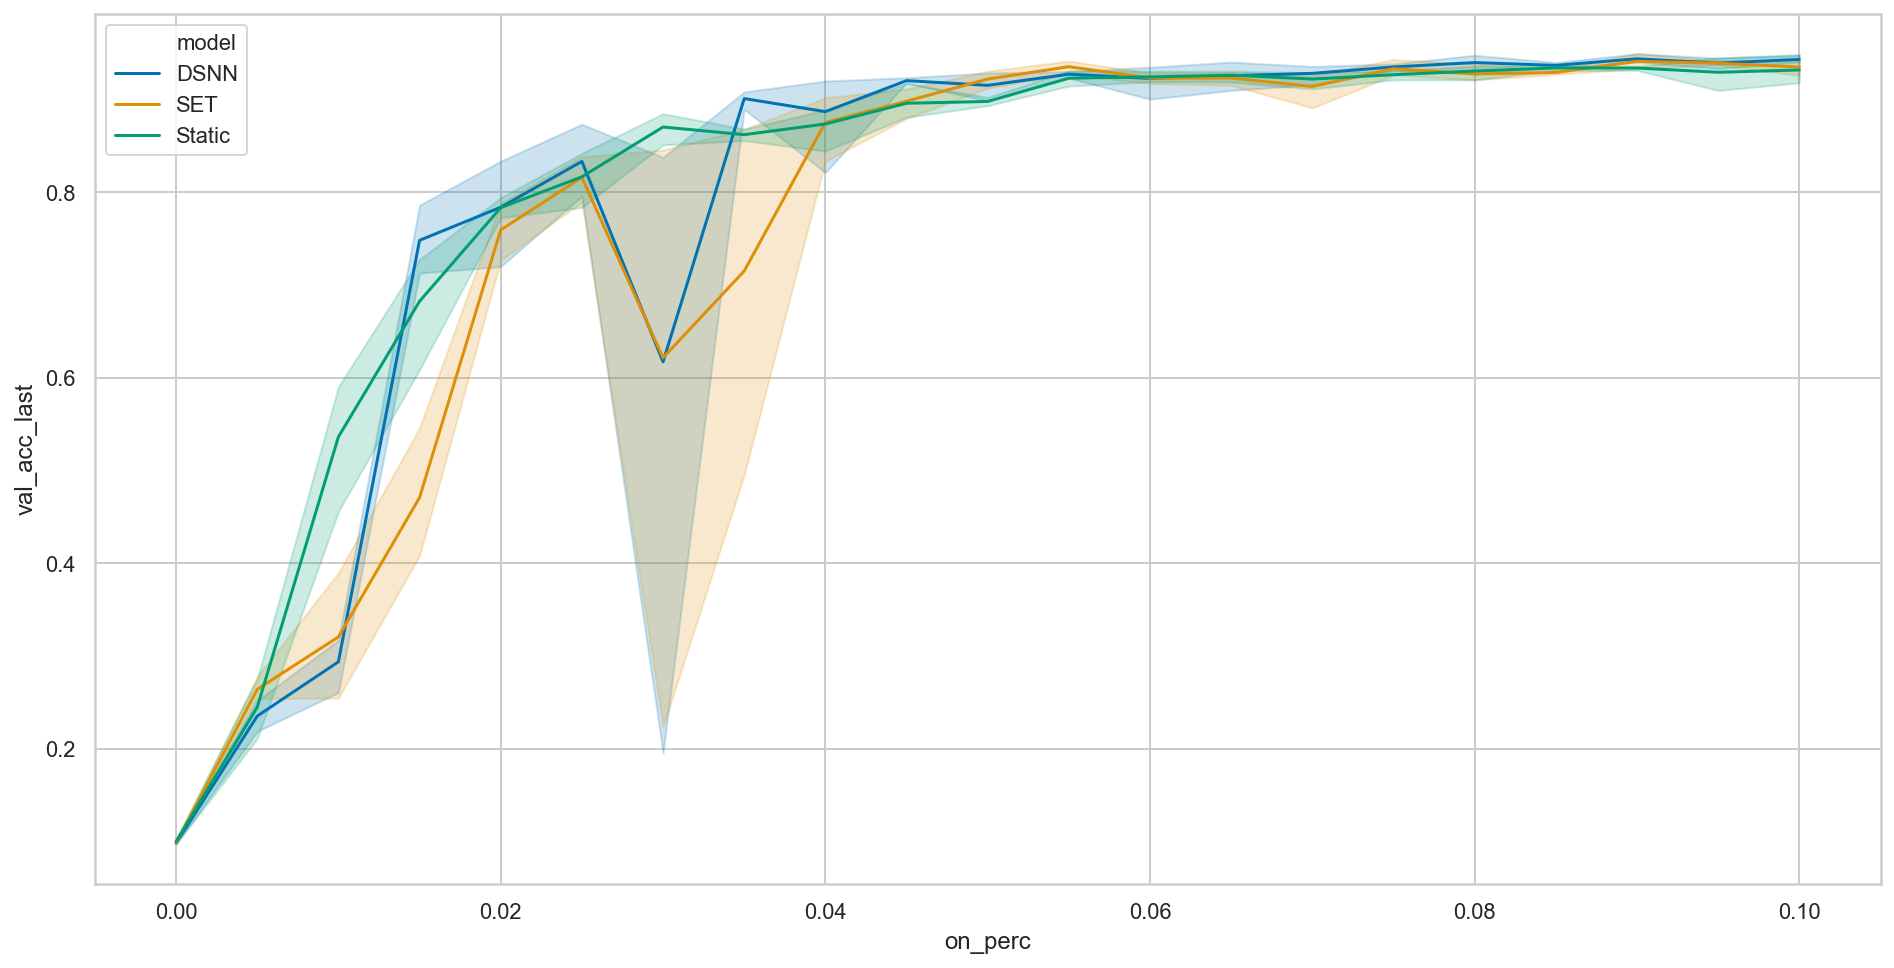

In [21]:
sns.lineplot(data=df_plot, x='on_perc', y='val_acc_last', hue='model')